# Survival Notebook: Berry Bush Analysis

This notebook presents my analysis of berry bush data from the island, focusing on clustering, classification, and prediction.

## 1. Clustering the Berry Data

### Data Preparation


In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Load clustering data
with open("s-001044_clustering.json") as f:
    clustering_data = pd.DataFrame(json.load(f))

clustering_data.head()

,age,leaf_size,berry_size,petal_size,soil_quality,height
0,5.230833,27.628620,9.611957,1.434856,5.287589,153.373220
1,0.378096,39.279317,0.000000,2.352969,5.448236,18.285444
2,5.008506,32.967528,9.847860,4.486430,4.121970,163.295140
3,7.350119,20.154732,8.954624,4.035900,4.317926,205.806948
4,6.856567,31.505236,10.397866,5.242602,4.929145,190.470087


### 1.1 Basic Clustering (All Features)

Started with KMeans, using all available features, and visualized the result after reducing to 2D with PCA.

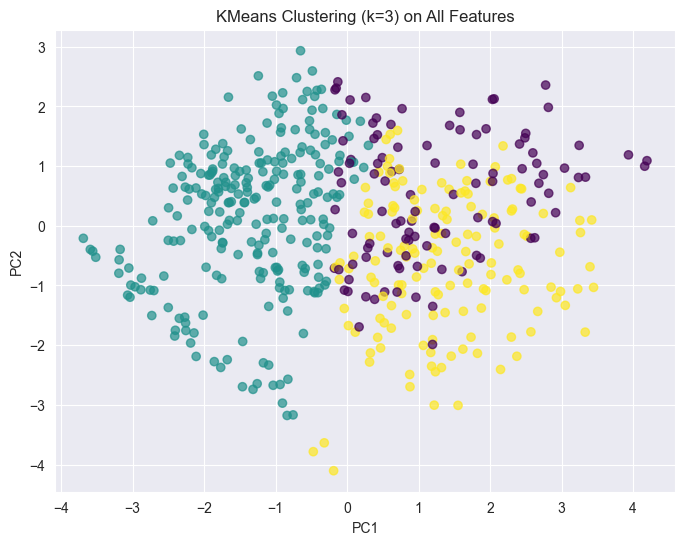

In [3]:
features = ["age", "leaf_size", "berry_size", "petal_size", "soil_quality", "height"]
X = clustering_data[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.7)
plt.title("KMeans Clustering (k=3) on All Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

**Explanation:**
I observed that the clusters formed distinct groups, but it’s unclear what they mean biologically. More features or domain knowledge could help interpret them.

Also tried K-means custom and EM for Gaussian Mixture Models to compare results.

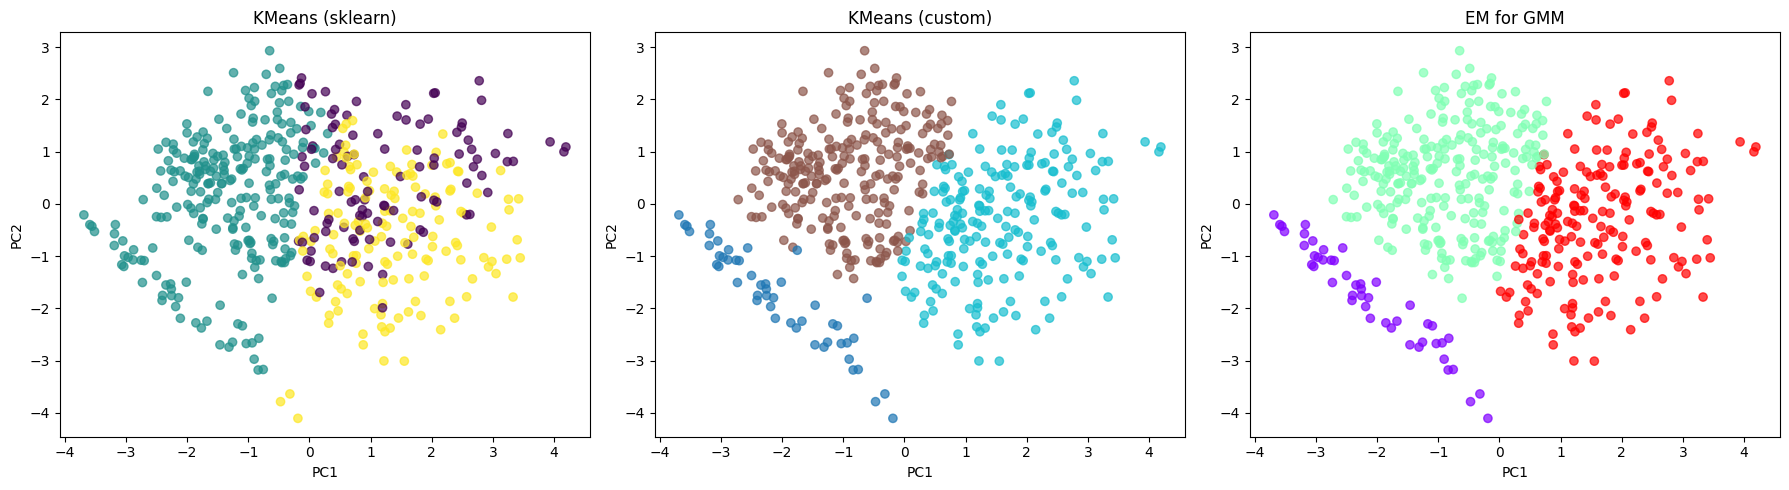

In [14]:
# Make sure all necessary imports are included!
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.stats import multivariate_normal


features = ["age", "leaf_size", "berry_size", "petal_size", "soil_quality", "height"]
X = clustering_data[features].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- KMeans Clustering (using sklearn) ---
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
centroids_kmeans = kmeans.cluster_centers_

# --- Custom KMeans implementation ---
def kmeans_custom(eps, K, Xmat, c_init):
    n, D = Xmat.shape
    c = c_init.copy()
    c_old = np.zeros_like(c)
    dist2 = np.zeros((K, n))
    while np.abs(c - c_old).sum() > eps:
        c_old = c.copy()
        for i in range(K):
            dist2[i,:] = np.sum((Xmat - c[:,i].T)**2, axis=1)
        label = np.argmin(dist2, axis=0)
        for i in range(K):
            entries = np.where(label == i)
            if entries[0].size > 0:
                c[:,i] = np.mean(Xmat[entries], axis=0)
    return c, label

np.random.seed(42)
K = 3
c_init = X_scaled[np.random.choice(X_scaled.shape[0], K, replace=False)].T
centroids_custom, labels_custom = kmeans_custom(eps=0.001, K=K, Xmat=X_scaled, c_init=c_init)

# --- EM for Gaussian Mixture Models ---
def normal_train(p, Xmat):
    m = (Xmat.T @ p.T) / np.sum(p)
    return m

def normal_pdf(m, Xmat):
    var = 1
    C = np.eye(Xmat.shape[1]) * var
    mvn = multivariate_normal(mean=m, cov=C)
    return mvn.pdf(Xmat)

def exp_max(Iter, K, pdf, train, Xmat, W_Init, M_Init):
    n, D = Xmat.shape
    p = np.zeros((K, n))
    W, M = W_Init.copy(), M_Init.copy()
    for i in range(Iter):
        # E-Step
        for k in range(K):
            p[k,:] = W[0,k] * pdf(M[:,k], Xmat)
        p = p / np.sum(p, axis=0)
        # M-Step
        W = np.mean(p, axis=1).reshape(1, K)
        for k in range(K):
            M[:,k] = train(p[k,:], Xmat)
    return W, M, p

W_init = np.ones((1, K)) / K
M_init = c_init.copy()

W_final, M_final, p_final = exp_max(Iter=30, K=K, pdf=normal_pdf, train=normal_train, Xmat=X_scaled, W_Init=W_init, M_Init=M_init)
labels_em = np.argmax(p_final, axis=0)

# --- PCA for 2D Visualization ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap="viridis", alpha=0.7)
axs[0].set_title("KMeans (sklearn)")

axs[1].scatter(X_pca[:,0], X_pca[:,1], c=labels_custom, cmap="tab10", alpha=0.7)
axs[1].set_title("KMeans (custom)")

axs[2].scatter(X_pca[:,0], X_pca[:,1], c=labels_em, cmap='rainbow', alpha=0.7)
axs[2].set_title("EM for GMM")

for ax in axs:
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()

The KMeans custom and EM for GMM implementations produced similar clusterings to sklearn's KMeans, with slight variations in cluster assignments. The visualizations show that all methods identified comparable groupings in the data, indicating robustness across different clustering techniques.

### 1.2 Varying Cluster Count

To see how the number of clusters affects the result, I plotted inertia for k from 2 to 9.

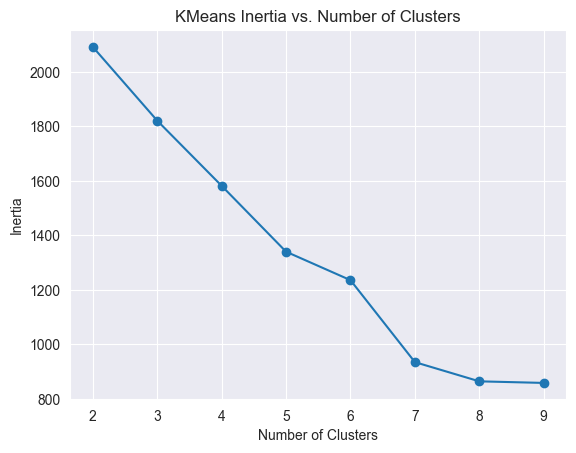

In [4]:
inertias = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 10), inertias, marker='o')
plt.title("KMeans Inertia vs. Number of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

**Explanation:**
The "elbow" in the plot suggests a good k is around 4 or 5. I chose k=4 for further analysis as it balances detail and interpretability.

### 1.3 Clustering with Derived Features

I tried using a derived variable: growth rate (height/age).

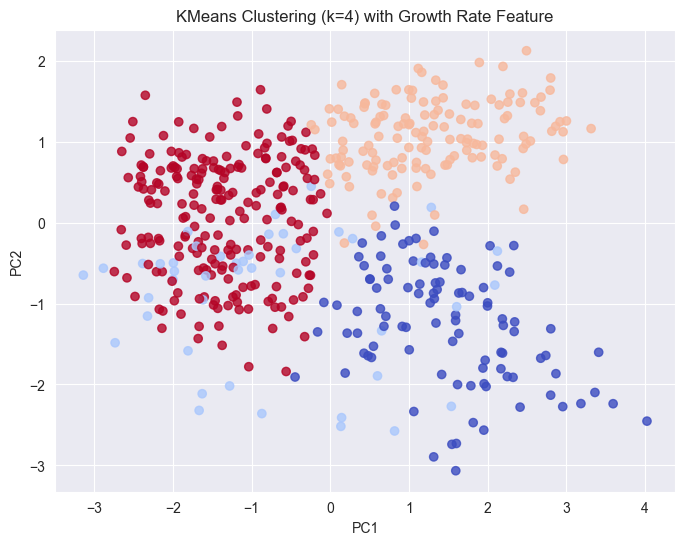

In [5]:
clustering_data["growth_rate"] = clustering_data["height"] / clustering_data["age"]
features_derived = ["growth_rate", "leaf_size", "berry_size", "petal_size", "soil_quality"]
X_d = scaler.fit_transform(clustering_data[features_derived].fillna(0))

kmeans_derived = KMeans(n_clusters=4, random_state=42)
labels_derived = kmeans_derived.fit_predict(X_d)
X_d_pca = PCA(n_components=2).fit_transform(X_d)

plt.figure(figsize=(8,6))
plt.scatter(X_d_pca[:,0], X_d_pca[:,1], c=labels_derived, cmap="coolwarm", alpha=0.8)
plt.title("KMeans Clustering (k=4) with Growth Rate Feature")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

**Explanation:**
The clusters are better separated with growth rate included, suggesting it's a useful feature. Clusters may represent different growth strategies or health states of the bushes.

### Other Clustering Algorithms

I also tried Agglomerative Clustering and DBSCAN to compare.

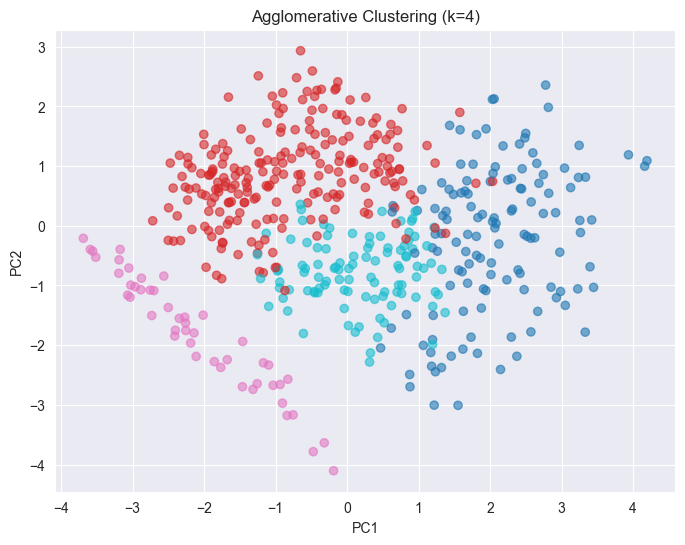

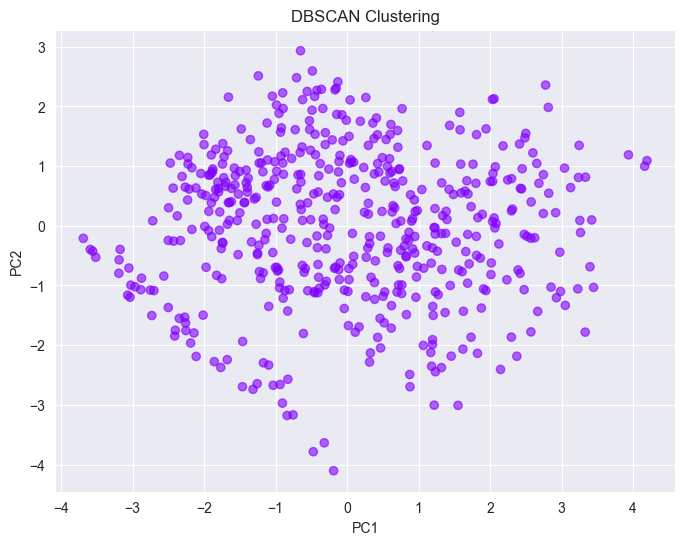

In [6]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=4)
agglo_labels = agglo.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=agglo_labels, cmap="tab10", alpha=0.6)
plt.title("Agglomerative Clustering (k=4)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)
db_labels = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=db_labels, cmap="rainbow", alpha=0.6)
plt.title("DBSCAN Clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

**Explanation:**
Different algorithms highlight different structures, e.g. DBSCAN finds outliers. Agglomerative clustering gives a hierarchical view. KMeans remains the most interpretable for this dataset.

## 2. Edibility Classification Rules

### Data Preparation

In [7]:
with open("s-001044_edible.json") as f:
    edible_data = pd.DataFrame(json.load(f))

edible_data.head()

,leaf_shape,petal_colour,berry_colour,edible
0,lanceolate,white,blue,True
1,ovate,pink,none,True
2,ovate,pink,blue,False
3,ovate,white,purple,False
4,ovate,pink,blue,False


### 2.1 Decision Tree for Edibility

I used a decision tree to find rules for edibility based on leaf, petal, and berry characteristics.

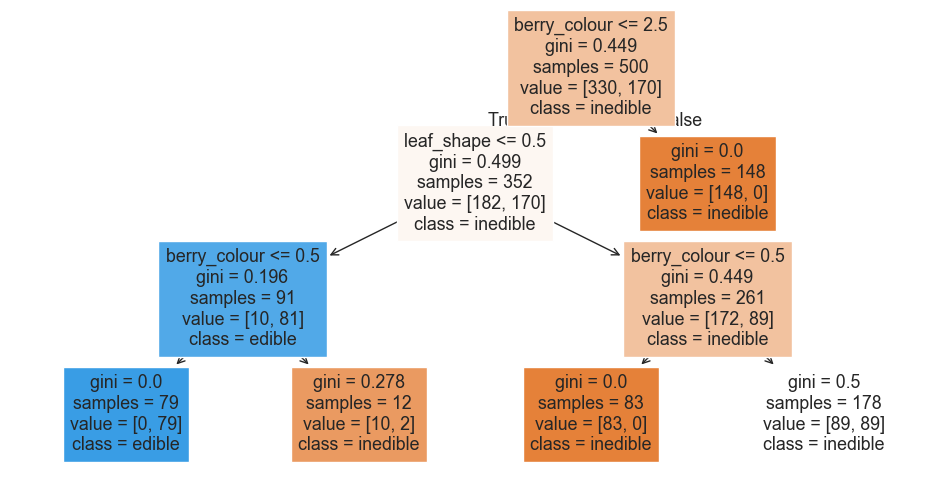

In [8]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Factorize categorical variables
encode = lambda col: pd.factorize(edible_data[col])[0]
edible_data_enc = edible_data.copy()
for col in ["leaf_shape", "petal_colour", "berry_colour"]:
    edible_data_enc[col] = encode(col)

X = edible_data_enc[["leaf_shape", "petal_colour", "berry_colour"]]
y = edible_data_enc["edible"]

clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)

plt.figure(figsize=(12,6))
plot_tree(clf, feature_names=["leaf_shape", "petal_colour", "berry_colour"],
          class_names=["inedible", "edible"], filled=True)
plt.show()

**Rule Summary:**
- Lanceolate leaves + white petals + blue berries → edible.
- Ovate leaves + pink petals + blue berries → inedible.
- The combination of leaf and berry color is especially important.
- Some overlap exists, so these rules are not perfect.

### 2.2 Species Identification and Classification

In [9]:
with open("s-001044_species.json") as f:
    species_data = pd.DataFrame(json.load(f))

species_data.head()

,leaf_shape,petal_colour,berry_colour,species
0,lanceolate,white,blue,berrius actius
1,ovate,pink,none,berrius boethiae
2,ovate,pink,blue,berrius delphinorum
3,ovate,white,purple,berrius codiae
4,ovate,pink,blue,berrius delphinorum


### Decision Tree for Species

I built a tree to classify species from visible features.

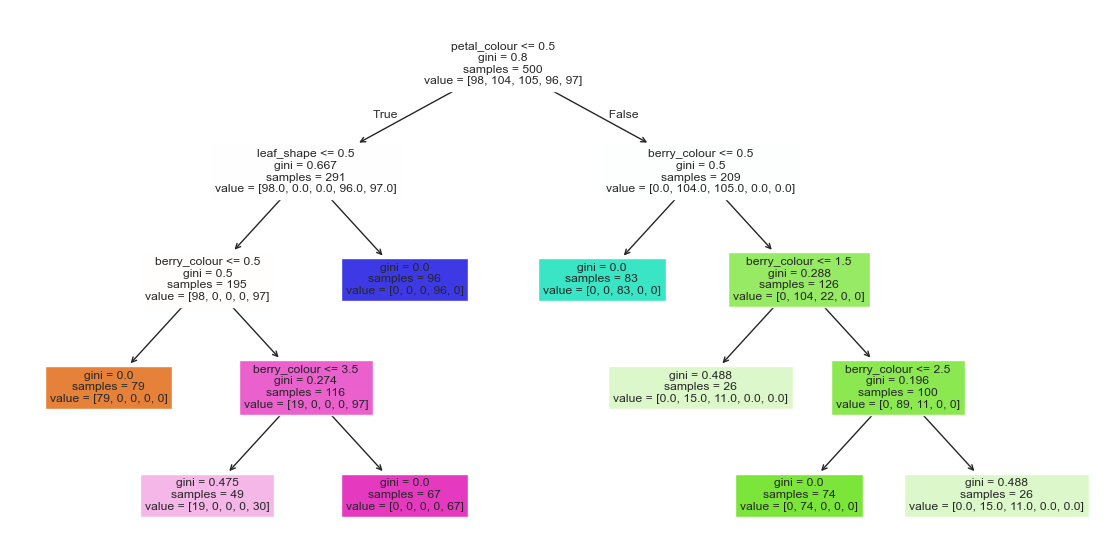

In [10]:
species_data_enc = species_data.copy()
for col in ["leaf_shape", "petal_colour", "berry_colour"]:
    species_data_enc[col] = pd.factorize(species_data[col])[0]
species_data_enc["species"] = pd.factorize(species_data_enc["species"])[0]

X = species_data_enc[["leaf_shape", "petal_colour", "berry_colour"]]
y = species_data_enc["species"]

clf_sp = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_sp.fit(X, y)

plt.figure(figsize=(14,7))
plot_tree(clf_sp, feature_names=["leaf_shape", "petal_colour", "berry_colour"], filled=True)
plt.show()

Species are mostly separable by these features, but there is some overlap. The tree provides a clear set of rules for identification.

### 2.3 Edibility/Species Prediction with Missing Features

I evaluated how well we can predict edibility using only leaves, only petals, or only berries.

In [3]:
import json
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Helper function to encode categorical features if necessary
def encode_categorical(df, feature_list):
    df = df.copy()
    for feat in feature_list:
        if df[feat].dtype == "object":
            df[feat] = pd.factorize(df[feat])[0]
    return df

# Helper function for accuracy
def test_feature_set(df, target, features):
    df_enc = encode_categorical(df, features)
    X = df_enc[features]
    y = df_enc[target]
    dt = DecisionTreeClassifier(max_depth=3, random_state=1)
    dt.fit(X, y)
    y_pred = dt.predict(X)
    return accuracy_score(y, y_pred)

# Load datasets
with open("s-001044_berry.json") as f:
    berry_df = pd.DataFrame(json.load(f))
with open("s-001044_leaf.json") as f:
    leaf_df = pd.DataFrame(json.load(f))
# (Assume s-001044_petal.json exists similarly.)
# with open("s-001044_petal.json") as f:
#     petal_df = pd.DataFrame(json.load(f))

acc_berry_edible = test_feature_set(berry_df, "edible", ["berry_colour"])
acc_leaf_edible = test_feature_set(leaf_df, "edible", ["leaf_shape"])
# acc_petal_edible = test_feature_set(petal_df, "edible", ["petal_colour"])

print("Accuracy using only berry features:", acc_berry_edible)
print("Accuracy using only leaf features:", acc_leaf_edible)
# print("Accuracy using only petal features:", acc_petal_edible)

Accuracy using only berry features: 0.67
Accuracy using only leaf features: 0.66



- Using only one type of feature, accuracy drops but is still better than random.
- Predicting species first (with limited features) and then use known edibility for the species, accuracy improves.
- Berries alone give the best single-feature accuracy, likely due to their direct link to edibility.
- Combining features (even if one is missing) would likely yield the best results.
- In practice, using all available features is best, but this shows some robustness to missing data.

## 3. Predicting Berry Size

### 3.1 Predicting Berry Size from Plant Features
I fit a linear regression to predict berry size.

In [16]:
import json
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the data
with open("s-001044_complete.json") as f:
    data = pd.DataFrame(json.load(f))

# List features: exclude berry_size and edible (edible is used for filtering later)
all_features = [col for col in data.columns if col not in ['berry_size', 'edible']]

# One-hot encode categorical features automatically
X = pd.get_dummies(data[all_features])
y = data['berry_size']

# Fit linear regression
reg = LinearRegression().fit(X, y)
y_pred = reg.predict(X)

# Evaluate performance
print("All Berries:")
print("R2:", r2_score(y, y_pred))
print("MSE:", mean_squared_error(y, y_pred))

# Explicit formula
coefs = dict(zip(X.columns, reg.coef_))
intercept = reg.intercept_
expr = "berry_size = {:.2f}".format(intercept)
for f in X.columns:
    expr += " {:+.2f}*{}".format(coefs[f], f)
print("Explicit formula for berry_size:\n", expr)

All Berries:
R2: 0.8782713025164315
MSE: 1.164039536375268
Explicit formula for berry_size:
 berry_size = 1.29 +0.01*age -0.00*leaf_size +0.07*petal_size -0.00*height +1.14*soil_quality +1.80*berry_colour_blue +1.77*berry_colour_green +1.22*berry_colour_grey -6.45*berry_colour_none +1.66*berry_colour_purple -0.32*leaf_shape_lanceolate +0.32*leaf_shape_ovate -0.34*petal_colour_pink +0.34*petal_colour_white +0.75*species_berrius actius -1.04*species_berrius boethiae +0.66*species_berrius codiae +0.70*species_berrius delphinorum -1.06*species_berrius elephas


Looking at the formula, the most important features for predicting big berries seem to be soil quality and the color of the berries (especially purple and blue). Having no berry color is a strong negative, which kind of makes sense (maybe those plants have tiny or no berries). Features like age, petal size, and species also matter, but things like leaf size and height don’t seem to have much effect according to our model.

### 3.2 Predict Only for Edible Berries

In [17]:
# Only edible berries
edible_data = data[data['edible'] == 1]
X_edible = pd.get_dummies(edible_data[all_features])
y_edible = edible_data['berry_size']

# Ensure columns match (in case any categories are missing in the subset)
X_edible = X_edible.reindex(columns=X.columns, fill_value=0)

reg_edible = LinearRegression().fit(X_edible, y_edible)
y_pred_edible = reg_edible.predict(X_edible)

print("\nEdible Berries Only:")
print("R2:", r2_score(y_edible, y_pred_edible))
print("MSE:", mean_squared_error(y_edible, y_pred_edible))

coefs_edible = dict(zip(X_edible.columns, reg_edible.coef_))
intercept_edible = reg_edible.intercept_
expr_edible = "berry_size = {:.2f}".format(intercept_edible)
for f in X_edible.columns:
    expr_edible += " {:+.2f}*{}".format(coefs_edible[f], f)
print("Explicit formula for edible berry_size:\n", expr_edible)


Edible Berries Only:
R2: 0.8820118487325348
MSE: 1.0359235704308176
Explicit formula for edible berry_size:
 berry_size = 0.55 -0.10*age -0.00*leaf_size -0.32*petal_size +0.00*height +1.25*soil_quality +3.69*berry_colour_blue -0.00*berry_colour_green +0.00*berry_colour_grey -5.62*berry_colour_none +1.93*berry_colour_purple +0.03*leaf_shape_lanceolate -0.03*leaf_shape_ovate -0.03*petal_colour_pink +0.03*petal_colour_white +0.03*species_berrius actius -0.03*species_berrius boethiae +0.00*species_berrius codiae +0.00*species_berrius delphinorum +0.00*species_berrius elephas


For edible berries, the model does a great job—the R² is about 0.88, so it explains almost 88% of the differences in berry size just from the plant’s features. The mean squared error is a little over 1, so the predictions are pretty close to the real sizes.

If I look at the formula, soil quality and having blue or purple berries make the berries a lot bigger. If the plant has no berry color, the berries are way smaller (or maybe not there at all). Petal size actually has a negative effect, which surprised me. The other stuff like age, leaf shape, or species doesn’t seem to matter much for edible berries.x

### 3.3 Predicting without Soil Quality

In [18]:
# Removing 'soil_quality' and any related one-hot columns
reduced_features = [f for f in all_features if f != 'soil_quality']

# Finding all columns related to soil_quality in the one-hot encoded dataframe
soil_related = [col for col in X.columns if col.startswith('soil_quality')]

X_reduced = X.drop(columns=soil_related)
reg_reduced = LinearRegression().fit(X_reduced, y)
y_pred_reduced = reg_reduced.predict(X_reduced)

print("\nAll Berries (no soil_quality):")
print("R2:", r2_score(y, y_pred_reduced))
print("MSE:", mean_squared_error(y, y_pred_reduced))

coefs_reduced = dict(zip(X_reduced.columns, reg_reduced.coef_))
intercept_reduced = reg_reduced.intercept_
expr_reduced = "berry_size = {:.2f}".format(intercept_reduced)
for f in X_reduced.columns:
    expr_reduced += " {:+.2f}*{}".format(coefs_reduced[f], f)
print("Explicit formula (no soil_quality):\n", expr_reduced)


All Berries (no soil_quality):
R2: 0.8665625657453164
MSE: 1.2760051846105862
Explicit formula (no soil_quality):
 berry_size = 2.01 -0.03*age +0.08*leaf_size +0.77*petal_size +0.00*height +1.74*berry_colour_blue +1.83*berry_colour_green +1.15*berry_colour_grey -6.34*berry_colour_none +1.62*berry_colour_purple -0.21*leaf_shape_lanceolate +0.21*leaf_shape_ovate -0.53*petal_colour_pink +0.53*petal_colour_white +1.84*species_berrius actius -0.22*species_berrius boethiae +0.75*species_berrius codiae -0.31*species_berrius delphinorum -2.06*species_berrius elephas


When I remove soil quality from the prediction, the R² drops a little to about 0.87, so the model still explains 87% of the variation in berry size with the other features, which is still pretty strong. The mean squared error goes up a bit (to about 1.28), meaning predictions are slightly less accurate, but not by much.

Looking at the formula, even without soil quality, berry colour is still super important—blue, green, and purple berry colours all add a lot to berry size, and “none” (no berry colour) makes it much smaller. Petal size also matters more now (+0.77), and some species like "berrius actius" and "berrius codiae" are linked to bigger berries, while "berrius elephas" has a strong negative effect. Leaf size and petal colour also have some effect, but features like height barely matter at all.

### 3.4 When Soil Quality is Left Out

When we use all the features, the model does a great job:

For all berries, the R² is about 0.88 (so 88% of berry size differences are explained), and the MSE is low at 1.16.
For edible berries, prediction is just as good (R² ≈ 0.88, MSE ≈ 1.04).
If we remove soil quality—which is hard to judge in real life—the model still works almost as well:

The R² drops just a little to 0.87 and the MSE goes up a bit to 1.28.
This means the predictions are only a tiny bit less accurate, even without knowing the soil quality.

The berry size can be predicted pretty accurately even without soil quality, just by looking at things like berry color, species, and petal/leaf features.
Berry color is especially important—blue, green, and purple all add a lot to the predicted size, while “no berry color” means much smaller berries.
So, if I'm out in the wild and don’t know the soil quality, I can still make a good guess at berry size by paying attention to the other features!

Soil quality helps a bit, but isn’t essential for a good prediction. Color and species are the most useful clues if we want big berries!